# Brain Tumor Detection using Convolutional Neural Networks

Convolutional Networks which efficency will be tested on brain tumor detection on MRI Images:
- VGG16
- VGG19
- ResNet
- DenseNet
- Xception
- EfficentNet

## Prepare data

Import libraries

In [1]:
import time
timer_start = time.time()
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.applications import vgg16, vgg19, resnet, densenet, xception, efficientnet
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from seaborn import heatmap
from random import randint
from typing import Iterable

load data

In [2]:
no_path = '../archive/brain_tumor_dataset/no'
yes_path = '../archive/brain_tumor_dataset/yes'
images = []
labels = [] # label 0 is no tumor, label 1 tumor occurs
for path in (no_path, yes_path):
    if path == no_path:
        default_label = 0
    elif path == yes_path:
        default_label = 1
    else:
        raise(Exception("What's going on?? No such file or directory"))
    
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        
        img = cv2.imread(img_path)
        
        # resize to convenient shape for CNN's
        img = cv2.resize(img, (224,224))
        
        # # cnn's need shape in rgb format, so i repeat one layer to 3
        # img = np.repeat(img, 3, axis=-1)
        
        images.append(img)
        labels.append(default_label)

images = np.array(images)
labels = np.array(labels)

check arrays

In [3]:
images[1].shape

(224, 224, 3)

In [4]:
print(labels[:10])
print(labels[-10:])

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]


show dataset

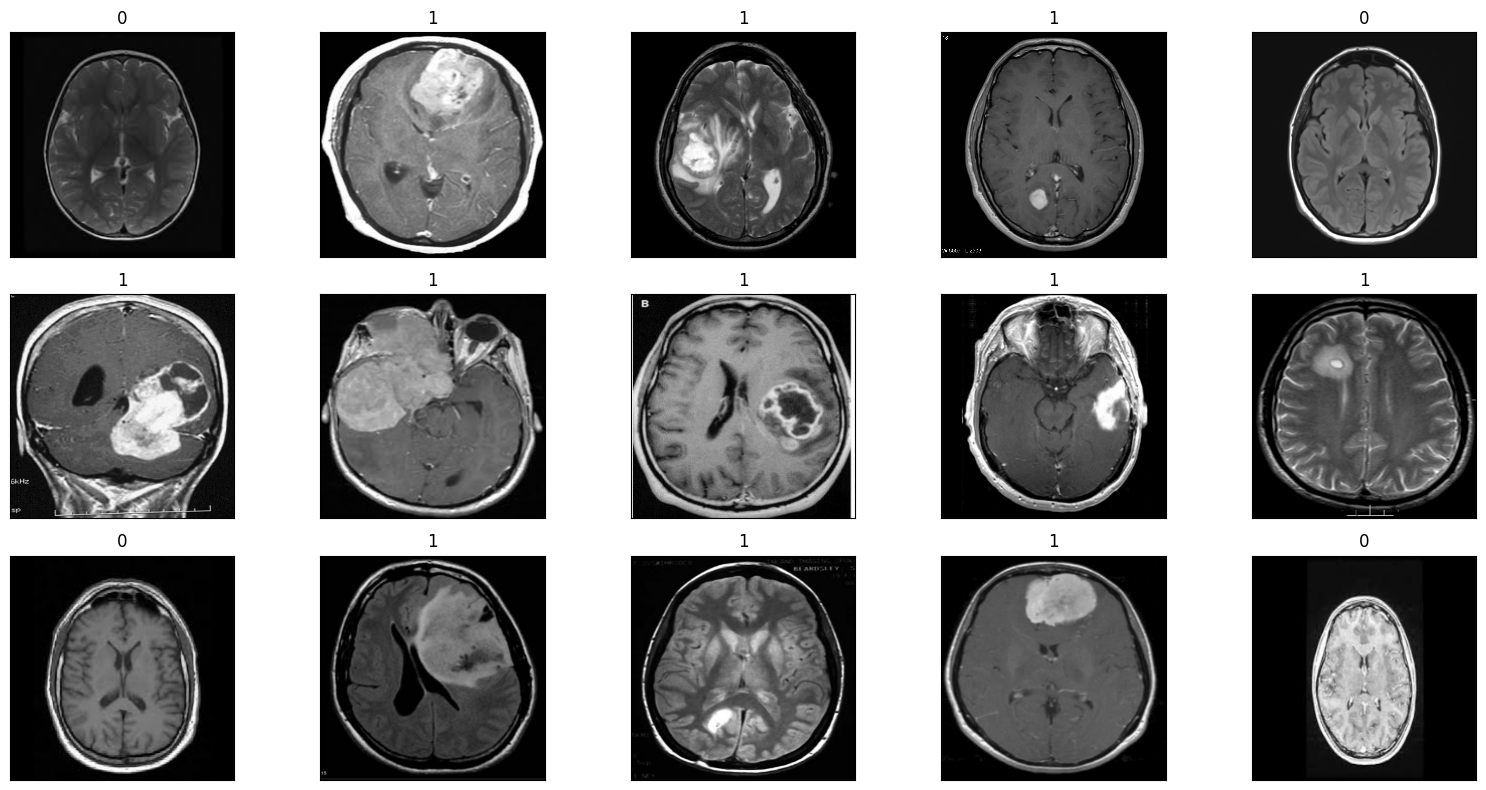

In [5]:
plt.figure(figsize=(16,8))
max_idx = len(labels)-1
for num in range(15):
    i = randint(0,max_idx)
    plt.subplot(3, 5, num + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(int(labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

split dataset

In [6]:
random_state = 509 # with train 0.7
def split_data(*images_list: Iterable, train_size: float=0.8, random_state: int=random_state):
    """Prepare data for CNN's. Split data by sklearn.model_selection.train_test_split, convert to np.array type, and categorize labels.

    Args:
        images_list (Iterable): Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
        train_size (float, Optional): Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. Defaults to 0.8.
        random_state (int, Optional): Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. Defaults to 112.
        
    """
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=train_size, random_state=random_state) # images is raw data without being preprocessed, 
    # optionally load here preprocessed data by cnn's own algorithm instead, for example vgg16_images (every cnn has its own prep. algorithm)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(images, 0.7)

# make labels categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(202, 224, 224, 3)
(51, 224, 224, 3)
(202, 2, 2)
(51, 2, 2)


## Learn models

### I. VGG16

#### model structure

*Default VGG16 using imagenet pretraining weights is created with 1000 classes. As imagenet is good in this case, it can be used there with good effectiveness. 
<br/>It is just needed to reduce number of classes to 2, by slightly adding fully-connected layers (disconnect top classification layers and add own solution).*

In [7]:
# preprocess images to fit for vgg16
vgg16_images = vgg16.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(vgg16_images)

vgg16_base_model = vgg16.VGG16(
    include_top=False, # set to false to not including classification layers
    # imagenet was trained with range 1000 of classes, we need just 2 - will be added in the next step
    weights='imagenet', # weights to be loaded, pretrained model imagenet, fits to MRI images well
    input_shape=(224, 224, 3),
)


##### LAYERS FOR BINARY CLASSIFICATION

# XXX simply add classification layer
# x = layers.Flatten()(vgg16_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
# vgg16_model = models.Model(inputs=vgg16_base_model.input, outputs=x)

# XXX classification layer + freezing weights from imagenet
for layer in vgg16_base_model.layers: # freeze the layers because models is already pretraind and it isn't neede to train it from scratch
    layer.trainable = False 
x = layers.Flatten()(vgg16_base_model.output)
x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
vgg16_model = models.Model(inputs=vgg16_base_model.input, outputs=x)

vgg16_model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 2)             │     50,178 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### fit model

*I eventually decided to use* **recall** *metric, to effective identification of sick patients.*

In [8]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
vgg16_predictions = vgg16_model.predict(X_test)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.7084 - loss: 4.4075 - recall: 0.7084 - val_accuracy: 0.8431 - val_loss: 3.6044 - val_recall: 0.8431
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9191 - loss: 1.2122 - recall: 0.9191 - val_accuracy: 0.8627 - val_loss: 2.7722 - val_recall: 0.8627
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9687 - loss: 0.2737 - recall: 0.9687 - val_accuracy: 0.9020 - val_loss: 2.9630 - val_recall: 0.9020
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.9770 - loss: 0.1529 - recall: 0.9770 - val_accuracy: 0.8627 - val_loss: 2.7597 - val_recall: 0.8627
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9951 - loss: 0.0571 - recall: 0.9951 - val_accuracy: 0.8824 - val_loss: 3.1264 - val_recall: 0.8824
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


#### outcome 
for train_test_split random_state=112<br/><br/>
**1st attempt - just added output layer and learn model from scratch** (Run - 13m 29s)(metric - accuracy)<br/>
| Epoch | 7 steps | Accuracy (train)  | Loss (train) | Val_accuracy (val) | Val_loss (val)  |
|-------|---------|-------------------|--------------|--------------------|-----------------|
| 1     | 24s     | 0.5762            | 112.1251     | 0.3922             | 4.9930          |
| 2     | 22s     | 0.5156            | 2.2461       | 0.7843             | 0.5228          |
| 3     | 22s     | 0.7047            | 0.6186       | 0.6863             | 0.5580          |
| 4     | 21s     | 0.6865            | 0.6362       | 0.7059             | 0.5259          |
| 5     | 21s     | 0.7037            | 0.5837       | 0.8235             | 0.4640          |

<br/><br/>
**2nd attempt - output layer + freeze pretrained neurons by imagenet** (Run - 2m 32s)(metric - accuracy)<br/>
| Epoch | 7 steps | Accuracy (train)  | Loss (train) | Val_accuracy (val) | Val_loss (val) |
|-------|---------|-------------------|--------------|--------------------|-----------------|
| 1     | 31s     | 0.6065            | 6.9229       | 0.8627             | 1.6175          |
| 2     | 31s     | 0.9848            | 0.1738       | 0.9020             | 1.0887          |
| 3     | 31s     | 0.9771            | 0.1235       | 0.9608             | 1.0088          |
| 4     | 28s     | 0.9973            | 0.0075       | 0.9020             | 0.9761          |
| 5     | 30s     | 0.9892            | 0.0294       | 0.9020             | 1.2780          |

<br/><br/>
**3rd attempt - same as in attempt before but on preprocessed data** (Run - 2m 34s)(metric - accuracy)<br/>
| Epoch | 7 steps | Accuracy (train)  | Loss (train) | Val_accuracy (val) | Val_loss (val) |
|-------|---------|-------------------|--------------|--------------------|-----------------|
| 1     | 33s     | 0.5573            | 13.6320      | 0.7647             | 4.8181          |
| 2     | 28s     | 0.8578            | 2.8767       | 0.8039             | 6.4838          |
| 3     | 31s     | 0.9186            | 1.2716       | 0.9020             | 1.9909          |
| 4     | 30s     | 0.9277            | 1.0792       | 0.8824             | 3.2656          |
| 5     | 31s     | 0.9919            | 0.1093       | 0.8627             | 5.4954

<br/><br/>
**4th attempt - change metric to more appropriate which is recall** (Run - 2m 23s)(metric - recall)<br/>
| Epoch | 7 steps | Recall (train) | Loss (train)  | Val_recall (val)  | Val_loss (val)  |
|-------|---------|----------------|---------------|-------------------|-----------------|
| 1     | 31      | 0.9811         | 0.1857        | 0.8824            | 2.6887          |
| 2     | 28      | 0.9842         | 0.0742        | 0.9216            | 2.3874          |
| 3     | 27      | 1.0000         | 3.6559e-05    | 0.9216            | 2.4587          |
| 4     | 27      | 0.9964         | 0.0031        | 0.8431            | 3.2493          |
| 5     | 28      | 0.9863         | 0.0408        | 0.8824            | 5.9009          |

classification report

In [9]:
vgg16_epoch = min(range(len(vgg16_history.history['val_loss'])), key=lambda i: vgg16_history.history['val_loss'][i])
print(f'Best epoch is: {vgg16_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
vgg16_predictions_classes = np.argmax(vgg16_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, vgg16_predictions_classes))

Best epoch is: 4

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.96      0.80      0.87        30

    accuracy                           0.86        51
   macro avg       0.86      0.88      0.86        51
weighted avg       0.88      0.86      0.86        51



confusion matrix

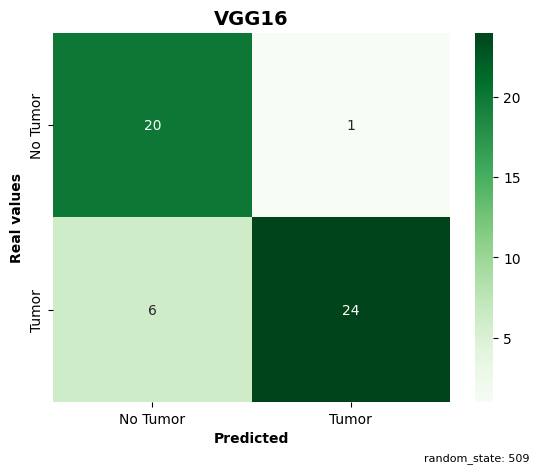

In [10]:
cf_matrix = confusion_matrix(y_test_labels, vgg16_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('VGG16', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_1_VGG16_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

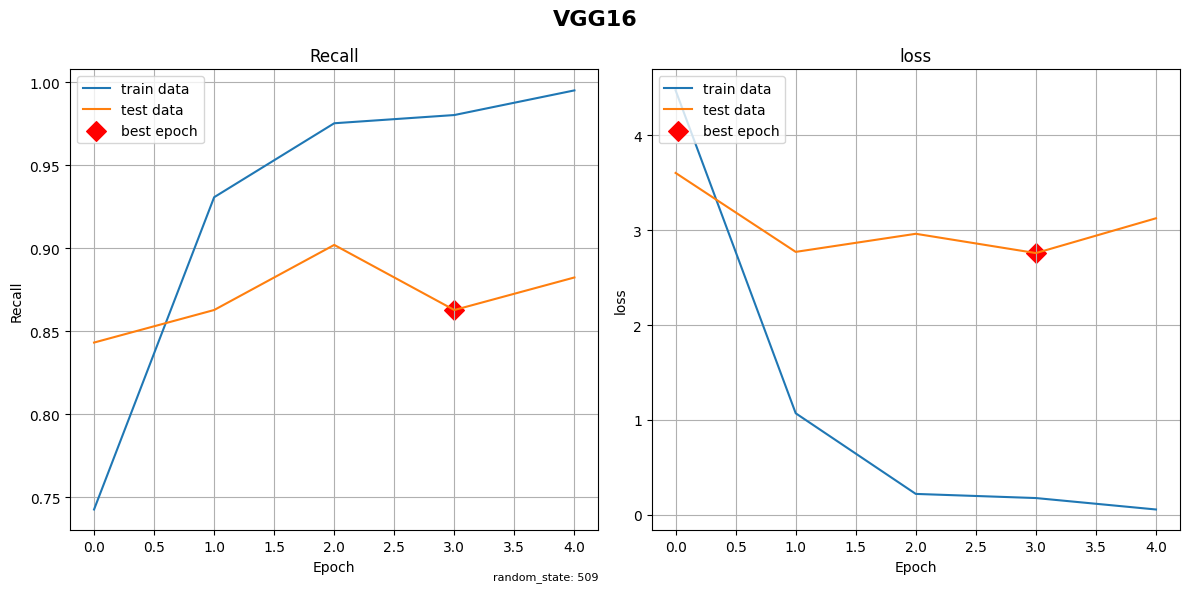

In [11]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('VGG16', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['recall'], label='train data')
plt.plot(vgg16_history.history['val_recall'], label='test data')
plt.scatter(vgg16_epoch, vgg16_history.history['val_recall'][vgg16_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='train data')
plt.plot(vgg16_history.history['val_loss'], label='test data')
plt.scatter(vgg16_epoch, vgg16_history.history['val_loss'][vgg16_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_1_VGG16_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

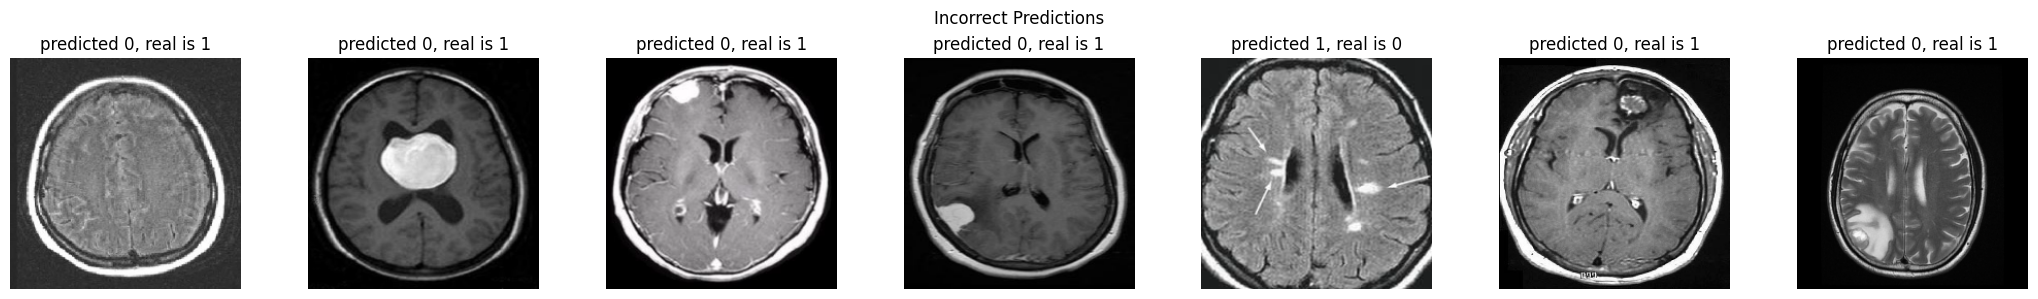

In [12]:
predicted_labels = np.argmax(vgg16_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### II. VGG19

#### model structure<br/>
*Network is similar to VGG16, but have 3 more layers - quadruple convolutional layers between pooling layers, whereas VGG16 has triple. Hence this makes VGG19 slightly deeper than VGG16.*

In [13]:
# preprocess images to fit for vgg19
vgg19_images = vgg19.preprocess_input(images)

X_train, X_test, y_train, y_test = split_data(vgg19_images)

vgg19_base_model = vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

##### LAYERS FOR BINARY CLASSIFICATION

# XXX simply add classification layer
# x = layers.Flatten()(vgg19_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
# vgg19_model = models.Model(inputs=vgg19_base_model.input, outputs=x)

# XXX classification layer + freezing weights from imagenet
for layer in vgg19_base_model.layers:
    layer.trainable = False 
x = layers.Flatten()(vgg19_base_model.output)
x = layers.Dense(2, activation='softmax')(x)  # 2 klasy
vgg19_model = models.Model(inputs=vgg19_base_model.input, outputs=x)

vgg19_model.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv4 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv4 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv4 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 2)             │     50,178 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,074,562 (76.58 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

#### fit model

In [14]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
vgg19_history = vgg19_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
vgg19_predictions = vgg19_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.6056 - loss: 8.8940 - recall: 0.6056 - val_accuracy: 0.9020 - val_loss: 3.6938 - val_recall: 0.9020
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.8449 - loss: 3.3667 - recall: 0.8449 - val_accuracy: 0.9608 - val_loss: 1.5757 - val_recall: 0.9608
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.9273 - loss: 1.0026 - recall: 0.9273 - val_accuracy: 0.8824 - val_loss: 1.6962 - val_recall: 0.8824
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.9390 - loss: 0.6439 - recall: 0.9390 - val_accuracy: 0.9216 - val_loss: 2.0967 - val_recall: 0.9216
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 1.0000 - loss: 5.8298e-04 - recall: 1.0000 - val_accuracy: 0.9216 - val_loss: 1.6514 - val_recall: 0.9216
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


#### outcome
for train_test_split random_state=112<br/><br/>
**1st attempt - all layers trainable, with output layer and training from scratch**(Run - 17m 10s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 29s     | 0.5136         | 94.9102      | 0.6863           | 0.6386         |
| 2     | 29s     | 0.5257         | 0.9217       | 0.6078           | 1.0933         |
| 3     | 28s     | 0.6338         | 0.8347       | 0.6275           | 0.6113         |
| 4     | 29s     | 0.6099         | 0.6199       | 0.7451           | 0.5353         |
| 5     | 29s     | 0.6626         | 0.6128       | 0.7451           | 0.4754         |

<br/><br/>
**2nd attempt - Same as before but initial layers from imagenet freezed**(Run - 3m 29s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 43s     | 0.5988         | 7.2193       | 0.7843           | 5.5934         |
| 2     | 42s     | 0.8599         | 2.7507       | 0.8431           | 2.5791         |
| 3     | 40s     | 0.9664         | 0.2773       | 0.8627           | 3.3716         |
| 4     | 42s     | 0.9779         | 0.2268       | 0.8824           | 2.8211         |
| 5     | 43s     | 0.9740         | 0.3116       | 0.8824           | 2.4380         |

*Results once again show that weights from pretrained model ImageNet gives better predictions than training from all layers of neurons from scratch, additionally training the model is significantly less time-consuming. Therefore, in upcoming models non-freezable layers will no longer be considered.*

classification report

In [15]:
vgg19_epoch = min(range(len(vgg19_history.history['val_loss'])), key=lambda i: vgg19_history.history['val_loss'][i])
print(f'Best epoch is: {vgg19_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
vgg19_predictions_classes = np.argmax(vgg19_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, vgg19_predictions_classes))

Best epoch is: 2

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.97      0.97      0.97        30

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



confusion matrix

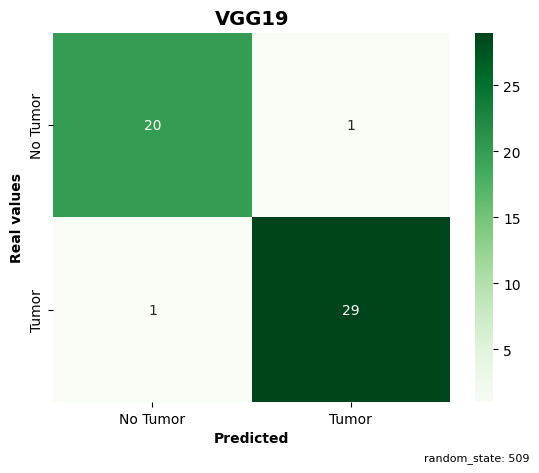

In [16]:
cf_matrix = confusion_matrix(y_test_labels, vgg19_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('VGG19', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_2_VGG19_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

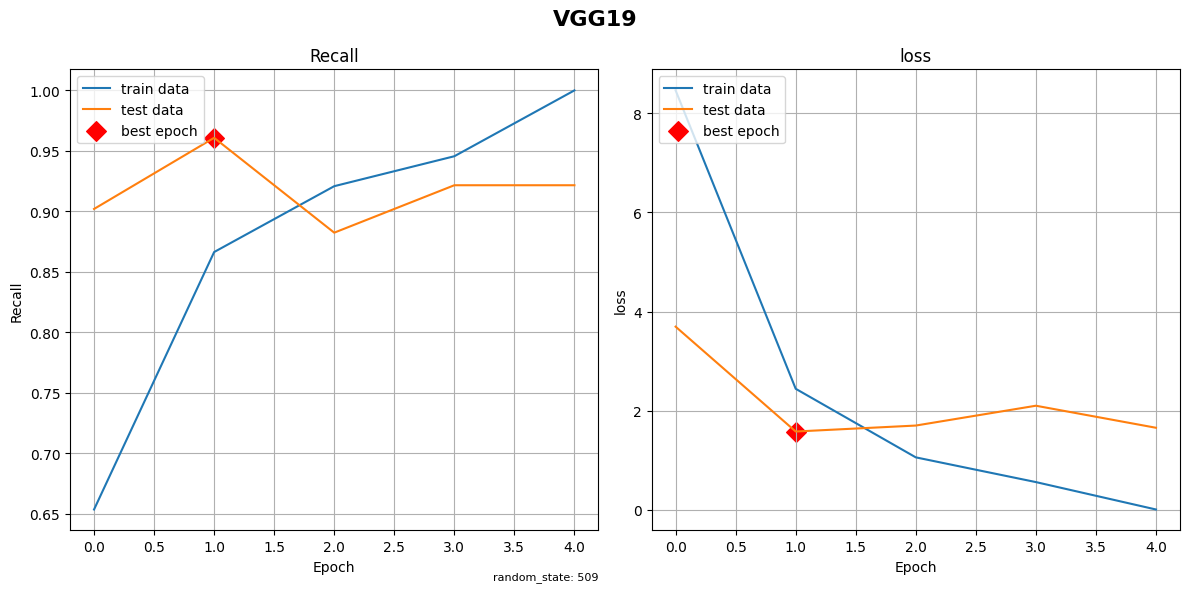

In [17]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('VGG19', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(vgg19_history.history['recall'], label='train data')
plt.plot(vgg19_history.history['val_recall'], label='test data')
plt.scatter(vgg19_epoch, vgg19_history.history['val_recall'][vgg19_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(vgg19_history.history['loss'], label='train data')
plt.plot(vgg19_history.history['val_loss'], label='test data')
plt.scatter(vgg19_epoch, vgg19_history.history['val_loss'][vgg19_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_2_VGG19_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

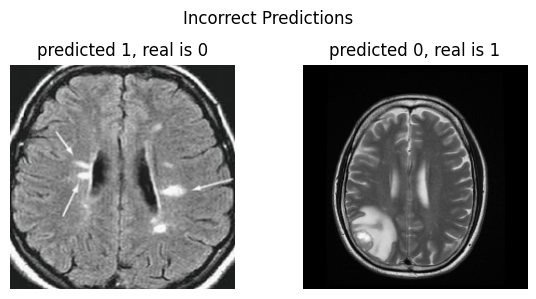

In [18]:
predicted_labels = np.argmax(vgg19_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### III. ResNet

#### model structure

*ResNet is much more deeper CNN than VGG's, because model consist of 50 layers will be used. This structure provides balanced depth and efficency. It operates on the principle of residual learning, with skip connections to allow gradients to flow trough network more effectively.*


In [19]:
# preprocess images to fit for resnet
resnet_images = resnet.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(resnet_images)

resnet_base_model = resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

##### LAYERS FOR BINARY CLASSIFICATION

# XXX classification layer + freezing weights from imagenet
for layer in resnet_base_model.layers:
    layer.trainable = False 
x = layers.Flatten()(resnet_base_model.output)
x = layers.Dense(2, activation='softmax')(x)
resnet_model = models.Model(inputs=resnet_base_model.input, outputs=x)

# make summary shorter (14 from head and 10 from tail)
resnet_model.summary(layer_range=(resnet_model.layers[0].name, resnet_model.layers[13].name), show_trainable=True)
print("\t. . .\t")
resnet_model.summary(layer_range=(resnet_model.layers[36].name, resnet_model.layers[49].name), show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 230,     │         0 │ input_layer_2… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 56, 56,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 56, 56,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 23,788,418 (90.75 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

	. . .	


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ conv2_block3_3_bn │ (None, 56, 56,  │     1,024 │ conv2_block3_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block3_add  │ (None, 56, 56,  │         0 │ conv2_block2_… │   -   │
│ (Add)             │ 256)            │           │ conv2_block3_… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block3_out  │ (None, 56, 56,  │         0 │ conv2_block3_… │   -   │
│ (Activation)      │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_1_c… │ (None, 28, 28,  │    32,896 │ conv2_block3_… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_1_bn │ (None, 28, 28,  │       512 │ conv3_block1_… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_1_r… │ (None, 28, 28,  │         0 │ conv3_block1_… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_2_c… │ (None, 28, 28,  │   147,584 │ conv3_block1_… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_2_bn │ (None, 28, 28,  │       512 │ conv3_block1_… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_2_r… │ (None, 28, 28,  │         0 │ conv3_block1_… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_0_c… │ (None, 28, 28,  │   131,584 │ conv2_block3_… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_3_c… │ (None, 28, 28,  │    66,048 │ conv3_block1_… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_0_bn │ (None, 28, 28,  │     2,048 │ conv3_block1_… │   N   │
│ (BatchNormalizat… │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_3_bn │ (None, 28, 28,  │     2,048 │ conv3_block1_… │   N   │
│ (BatchNormalizat… │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3_block1_add  │ (None, 28, 28,  │         0 │ conv3_block1_… │   -   │
│ (Add)             │ 512)            │           │ conv3_block1_… │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 23,788,418 (90.75 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### fit model

In [20]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
resnet_history = resnet_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
resnet_predictions = resnet_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5753 - loss: 4.8593 - recall: 0.5753 - val_accuracy: 0.9020 - val_loss: 1.4860 - val_recall: 0.9020
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8966 - loss: 1.6613 - recall: 0.8966 - val_accuracy: 0.9608 - val_loss: 1.5482 - val_recall: 0.9608
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9405 - loss: 0.7087 - recall: 0.9405 - val_accuracy: 0.9412 - val_loss: 0.9404 - val_recall: 0.9412
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9851 - loss: 0.0881 - recall: 0.9851 - val_accuracy: 0.9412 - val_loss: 1.4500 - val_recall: 0.9412
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9885 - loss: 0.0642 - recall: 0.9885 - val_accuracy: 0.9216 - val_loss: 1.5486 - val_recall: 0.9216
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 1.0000 - loss: 4.0771e-04 - recall: 1.0000 - val_accuracy: 0.9412 - val_loss: 1.0946 - val_recall: 0.9412
1/2 ━━━━━━━━━━━━━━━━━━━━

#### outcome
for train_test_split random_state=112<br/><br/>
**1st attempt - all layers freezed, with output layer**(Run - 1m 30s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 25s     | 0.5915         | 5.7755       | 0.8431           | 2.6162         |
| 2     | 16s     | 0.9248         | 0.8794       | 0.9216           | 1.4296         |
| 3     | 17s     | 0.9659         | 0.4296       | 0.9412           | 1.8865         |
| 4     | 16s     | 0.9912         | 0.0453       | 0.9020           | 1.2430         |
| 5     | 16s     | 0.9945         | 0.0314       | 0.9020           | 1.2278         |


classification report

In [21]:
resnet_epoch = min(range(len(resnet_history.history['val_loss'])), key=lambda i: resnet_history.history['val_loss'][i])
print(f'Best epoch is: {resnet_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
resnet_predictions_classes = np.argmax(resnet_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, resnet_predictions_classes))

Best epoch is: 3

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.97      0.93      0.95        30

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



confusion matrix

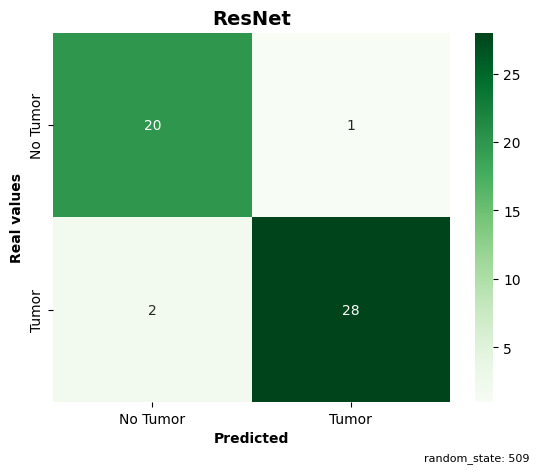

In [22]:
cf_matrix = confusion_matrix(y_test_labels, resnet_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('ResNet', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_3_ResNet_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

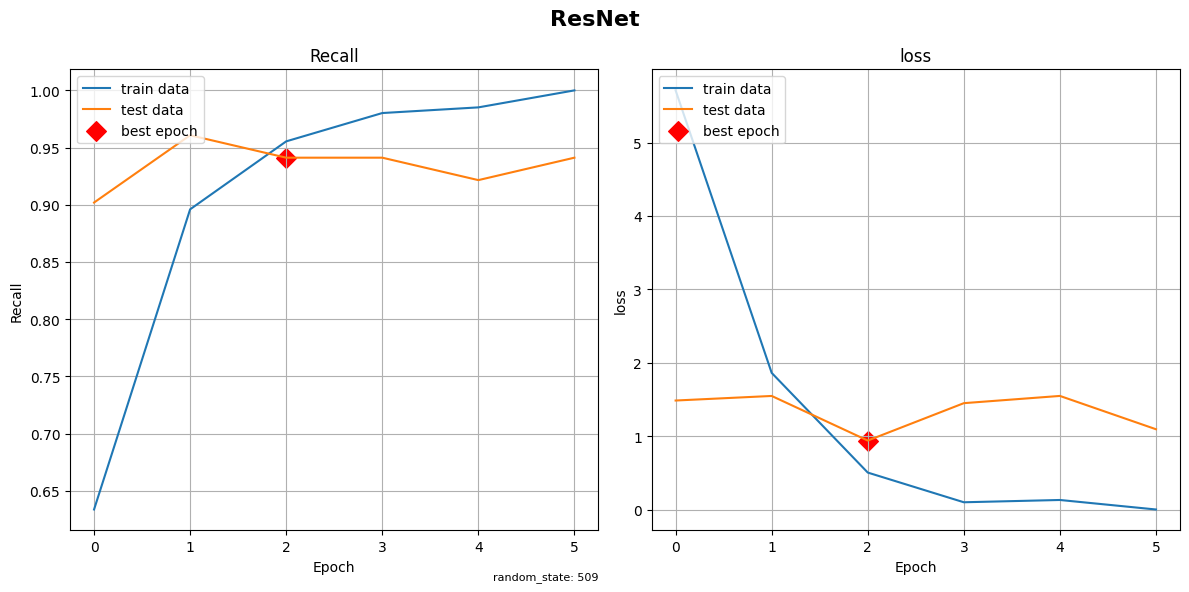

In [23]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('ResNet', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['recall'], label='train data')
plt.plot(resnet_history.history['val_recall'], label='test data')
plt.scatter(resnet_epoch, resnet_history.history['val_recall'][resnet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='train data')
plt.plot(resnet_history.history['val_loss'], label='test data')
plt.scatter(resnet_epoch, resnet_history.history['val_loss'][resnet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_3_ResNet_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

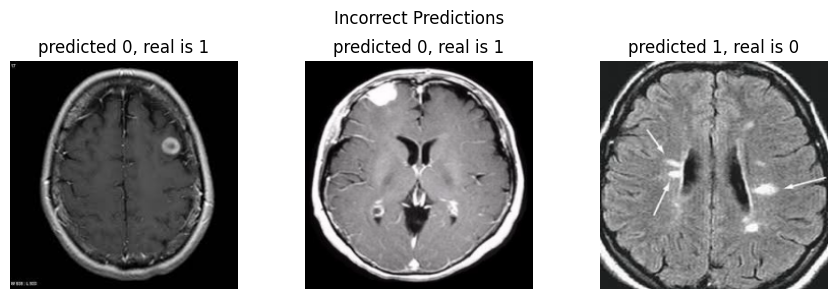

In [24]:
predicted_labels = np.argmax(resnet_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### IV. DenseNet

#### model structure

*Let's dive deeper into deep learning methods, by considering DenseNet. Among implementations with 121, 169 and 201 layers, I decided to take 121-layer, to balance efficency and depth, similar to ResNet. DenseNet is based on a structure where each layer receives inputs from all preceding layers and passes its own feature maps to all subsequent layers, improving feature reuse and gradient flow troughout the network.*


In [25]:
# preprocess images to fit for xception
densenet_images = densenet.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(densenet_images)

densenet_base_model = densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

##### LAYERS FOR BINARY CLASSIFICATION

# XXX classification layer + freezing weights from imagenet
for layer in densenet_base_model.layers:
    layer.trainable = False 
x = layers.Flatten()(densenet_base_model.output)
x = layers.Dense(2, activation='softmax')(x)

# XXX freezing all EXCEPT LAST 3 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in densenet_base_model.layers[:-6]:
#     layer.trainable = False 
# x = layers.Flatten()(densenet_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# XXX freezing all EXCEPT LAST 30 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in densenet_base_model.layers[:-50]:
#     layer.trainable = False 
# x = layers.Flatten()(densenet_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# assemble model
densenet_model = models.Model(inputs=densenet_base_model.input, outputs=x)

# make summary shorter (14 from head and 10 from tail)
densenet_model.summary(layer_range=(densenet_model.layers[0].name, densenet_model.layers[13].name), show_trainable=True)
print("\t. . .\t")
densenet_model.summary(layer_range=(densenet_model.layers[-14].name, densenet_model.layers[-1].name), show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ zero_padding2d    │ (None, 230,     │         0 │ input_layer_3… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,408 │ zero_padding2… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ zero_padding2d_1  │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 56, 56,  │         0 │ zero_padding2… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 56, 56,  │       256 │ pool1[0][0]    │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     8,192 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       512 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,864 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_con… │ (None, 56, 56,  │         0 │ pool1[0][0],   │   -   │
│ (Concatenate)     │ 96)             │           │ conv2_block1_… │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 7,137,858 (27.23 MB)

 Trainable params: 100,354 (392.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

	. . .	


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ conv5_block15_1_… │ (None, 7, 7,    │         0 │ conv5_block15… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block15_2_… │ (None, 7, 7,    │    36,864 │ conv5_block15… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block15_co… │ (None, 7, 7,    │         0 │ conv5_block14… │   -   │
│ (Concatenate)     │ 992)            │           │ conv5_block15… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_0_… │ (None, 7, 7,    │     3,968 │ conv5_block15… │   N   │
│ (BatchNormalizat… │ 992)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_0_… │ (None, 7, 7,    │         0 │ conv5_block16… │   -   │
│ (Activation)      │ 992)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_1_… │ (None, 7, 7,    │   126,976 │ conv5_block16… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_1_… │ (None, 7, 7,    │       512 │ conv5_block16… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_1_… │ (None, 7, 7,    │         0 │ conv5_block16… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_2_… │ (None, 7, 7,    │    36,864 │ conv5_block16… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv5_block16_co… │ (None, 7, 7,    │         0 │ conv5_block15… │   -   │
│ (Concatenate)     │ 1024)           │           │ conv5_block16… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bn                │ (None, 7, 7,    │     4,096 │ conv5_block16… │   N   │
│ (BatchNormalizat… │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ relu (Activation) │ (None, 7, 7,    │         0 │ bn[0][0]       │   -   │
│                   │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ flatten_3         │ (None, 50176)   │         0 │ relu[0][0]     │   -   │
│ (Flatten)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_3 (Dense)   │ (None, 2)       │   100,354 │ flatten_3[0][… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 7,137,858 (27.23 MB)

 Trainable params: 100,354 (392.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

#### fit model

In [26]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
densenet_history = densenet_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
densenet_predictions = densenet_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5814 - loss: 16.7500 - recall: 0.5814 - val_accuracy: 0.7647 - val_loss: 5.9307 - val_recall: 0.7647
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7846 - loss: 10.3949 - recall: 0.7846 - val_accuracy: 0.7647 - val_loss: 7.1593 - val_recall: 0.7647
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8006 - loss: 6.0254 - recall: 0.8006 - val_accuracy: 0.8039 - val_loss: 2.9574 - val_recall: 0.8039
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7968 - loss: 4.6124 - recall: 0.7968 - val_accuracy: 0.7647 - val_loss: 5.1667 - val_recall: 0.7647
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8851 - loss: 1.3273 - recall: 0.8851 - val_accuracy: 0.8039 - val_loss: 3.8659 - val_recall: 0.8039
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9192 - loss: 0.5170 - recall: 0.9192 - val_accuracy: 0.5686 - val_loss: 6.4483 - val_recall: 0.5686
2/2 ━━━━━━━━━━━━━━━━━━━━ 1

#### outcome
for train_test_split random_state=112<br/><br/>
**1st attempt - all layers freezed, output layer**(Run - 1m 59s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 41s     | 0.4998         | 31.2850      | 0.3922           | 25.5569        |
| 2     | 20s     | 0.6250         | 16.2186      | 0.7059           | 18.7571        |
| 3     | 19s     | 0.7556         | 14.6348      | 0.6863           | 13.8961        |
| 4     | 19s     | 0.7647         | 7.2830       | 0.7843           | 10.6898        |
| 5     | 19s     | 0.8697         | 4.1206       | 0.7059           | 5.7831         |

<br/><br/>
**2nd attempt - all layers freezed expect last 3 trainable layers, output layer**(Run - 1m 52s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 36s     | 0.5810         | 4.0650       | 0.8431           | 3.3558         |
| 2     | 19s     | 0.8085         | 2.4172       | 0.6275           | 7.8175         |
| 3     | 19s     | 0.8113         | 1.6786       | 0.7843           | 1.7173         |
| 4     | 19s     | 0.7744         | 1.6611       | 0.7059           | 7.2201         |
| 5     | 19s     | 0.8988         | 0.8258       | 0.7255           | 4.9952         |

<br/><br/>
**3rd attempt - all layers freezed expect last 30 trainable layers, output layer**(Run - 1m 30s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 38s     | 0.6037         | 4.5298       | 0.6667           | 19.5060        |
| 2     | 20s     | 0.7552         | 4.0072       | 0.4706           | 30.9723        |
| 3     | 20s     | 0.8022         | 1.4377       | 0.6667           | 14.6322        |
| 4     | 20s     | 0.8797         | 0.8117       | 0.8039           | 3.8600         |
| 5     | 20s     | 0.8996         | 0.4093       | 0.7647           | 2.2875         |


classification report

In [27]:
densenet_epoch = min(range(len(densenet_history.history['val_loss'])), key=lambda i: densenet_history.history['val_loss'][i])
print(f'Best epoch is: {densenet_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
densenet_predictions_classes = np.argmax(densenet_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, densenet_predictions_classes))

Best epoch is: 3

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72        21
           1       0.78      0.93      0.85        30

    accuracy                           0.80        51
   macro avg       0.82      0.78      0.79        51
weighted avg       0.81      0.80      0.80        51



confusion matrix

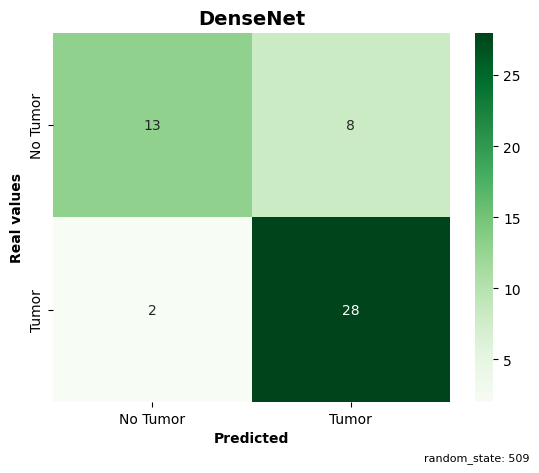

In [28]:
cf_matrix = confusion_matrix(y_test_labels, densenet_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('DenseNet', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_4_DenseNet_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

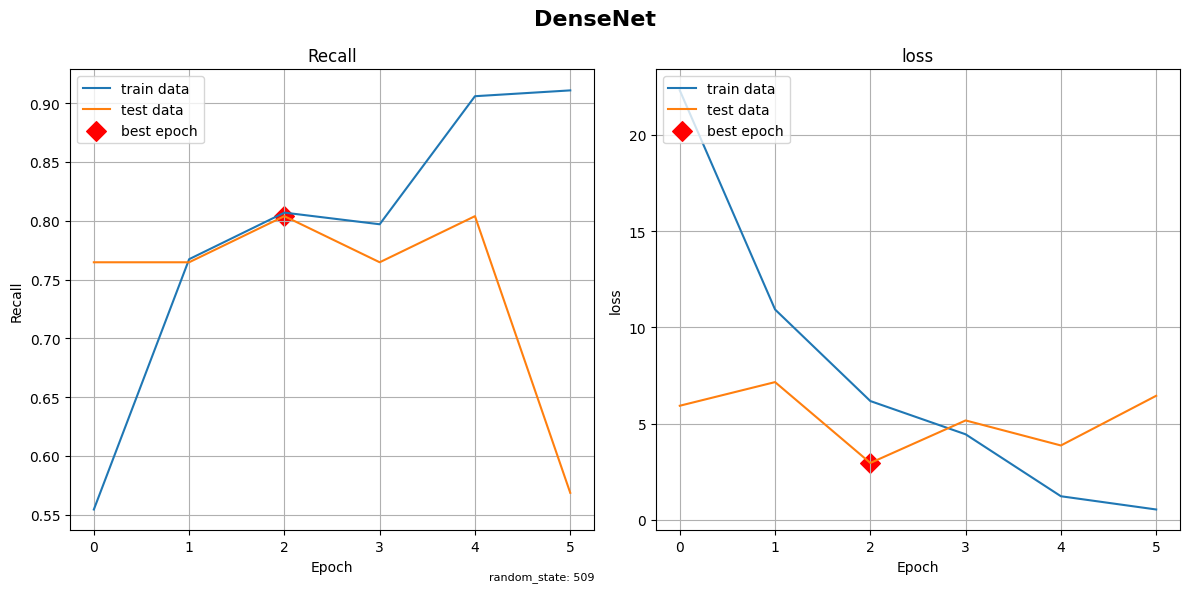

In [29]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('DenseNet', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(densenet_history.history['recall'], label='train data')
plt.plot(densenet_history.history['val_recall'], label='test data')
plt.scatter(densenet_epoch, densenet_history.history['val_recall'][densenet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(densenet_history.history['loss'], label='train data')
plt.plot(densenet_history.history['val_loss'], label='test data')
plt.scatter(densenet_epoch, densenet_history.history['val_loss'][densenet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_4_DenseNet_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

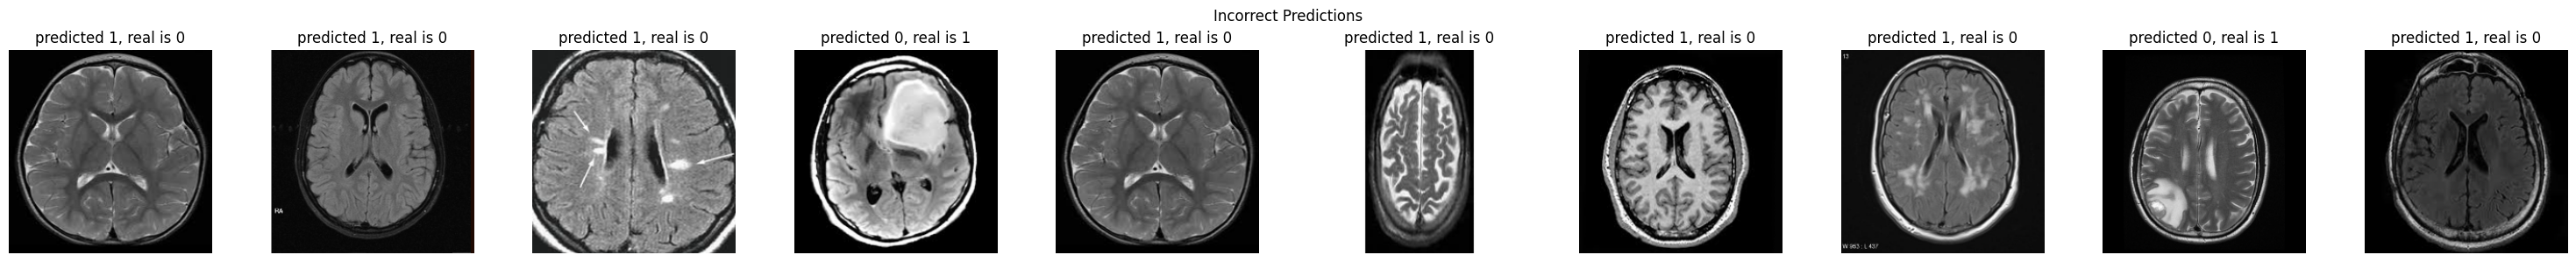

In [30]:
predicted_labels = np.argmax(densenet_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### V. Xception

#### model structure

*XCeption is extended idea of Inception CNN, which was primarily created to capture complex features while remaining on relevant level of efficency and performance. Connected 71 layers use depthwise separable convolutions to reduce number of parameters and computational cost.*

In [31]:
# preprocess images to fit for XCeption
xception_images = xception.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(xception_images)

xception_base_model = xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

##### LAYERS FOR BINARY CLASSIFICATION

# XXX classification layer + freezing weights from imagenet
for layer in xception_base_model.layers:
    layer.trainable = False 
x = layers.Flatten()(xception_base_model.output)
x = layers.Dense(2, activation='softmax')(x)

# XXX freezing all EXCEPT LAST 4 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in xception_base_model.layers[:-6]:
#     layer.trainable = False 
# x = layers.Flatten()(xception_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# XXX freezing all EXCEPT LAST 15 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in xception_base_model.layers[:-32]:
#     layer.trainable = False 
# x = layers.Flatten()(xception_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# assemble model
xception_model = models.Model(inputs=xception_base_model.input, outputs=x)

# make summary shorter (14 from head and 10 from tail)
xception_model.summary(layer_range=(xception_model.layers[0].name, xception_model.layers[13].name), show_trainable=True)
print("\t. . .\t")
xception_model.summary(layer_range=(xception_model.layers[-14].name, xception_model.layers[-1].name), show_trainable=True)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 111,     │       864 │ input_layer_4… │   N   │
│ (Conv2D)          │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 111,     │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 111,     │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 109,     │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 109,     │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 109,     │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 109,     │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 109, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 109,     │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 109, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 109,     │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 109, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 109,     │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 109, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 109,     │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 109, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 55, 55,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 55, 55,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 21,062,186 (80.35 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

	. . .	


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ block13_sepconv2… │ (None, 14, 14,  │         0 │ block13_sepco… │   -   │
│ (Activation)      │ 728)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block13_sepconv2  │ (None, 14, 14,  │   752,024 │ block13_sepco… │   N   │
│ (SeparableConv2D) │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block13_sepconv2… │ (None, 14, 14,  │     4,096 │ block13_sepco… │   N   │
│ (BatchNormalizat… │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 7, 7,    │   745,472 │ add_10[0][0]   │   N   │
│                   │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block13_pool      │ (None, 7, 7,    │         0 │ block13_sepco… │   -   │
│ (MaxPooling2D)    │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 7, 7,    │     4,096 │ conv2d_3[0][0] │   N   │
│ (BatchNormalizat… │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_11 (Add)      │ (None, 7, 7,    │         0 │ block13_pool[… │   -   │
│                   │ 1024)           │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv1  │ (None, 7, 7,    │ 1,582,080 │ add_11[0][0]   │   N   │
│ (SeparableConv2D) │ 1536)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv1… │ (None, 7, 7,    │     6,144 │ block14_sepco… │   N   │
│ (BatchNormalizat… │ 1536)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv1… │ (None, 7, 7,    │         0 │ block14_sepco… │   -   │
│ (Activation)      │ 1536)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv2  │ (None, 7, 7,    │ 3,159,552 │ block14_sepco… │   N   │
│ (SeparableConv2D) │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv2… │ (None, 7, 7,    │     8,192 │ block14_sepco… │   N   │
│ (BatchNormalizat… │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block14_sepconv2… │ (None, 7, 7,    │         0 │ block14_sepco… │   -   │
│ (Activation)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ flatten_4         │ (None, 100352)  │         0 │ block14_sepco… │   -   │
│ (Flatten)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_4 (Dense)   │ (None, 2)       │   200,706 │ flatten_4[0][… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 21,062,186 (80.35 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

#### fit model

In [32]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
xception_history = xception_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
xception_predictions = xception_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4790 - loss: 44.6413 - recall: 0.4790 - val_accuracy: 0.6275 - val_loss: 56.4918 - val_recall: 0.6275
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6841 - loss: 28.4291 - recall: 0.6841 - val_accuracy: 0.7451 - val_loss: 15.4695 - val_recall: 0.7451
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7487 - loss: 13.4035 - recall: 0.7487 - val_accuracy: 0.7255 - val_loss: 31.8397 - val_recall: 0.7255
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8348 - loss: 8.9713 - recall: 0.8348 - val_accuracy: 0.7843 - val_loss: 18.3437 - val_recall: 0.7843
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8758 - loss: 3.0924 - recall: 0.8758 - val_accuracy: 0.8431 - val_loss: 17.6445 - val_recall: 0.8431
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


#### outcome
for train_test_split random_state=112<br/><br/>

**1st attempt - all layers freezed, output layer**(Run - 1m 59s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 23s     | 0.9657         | 0.1627       | 0.8431           | 2.8574         |
| 2     | 20s     | 0.9765         | 0.0846       | 0.8235           | 2.8811         |
| 3     | 21s     | 0.9879         | 0.0468       | 0.8235           | 3.1165         |
| 4     | 21s     | 0.9792         | 0.0497       | 0.7843           | 2.7829         |
| 5     | 23s     | 0.9964         | 0.0502       | 0.8824           | 1.0595         |

<br/><br/>
**2nd attempt - all layers freezed expect last 4 trainable layers, output layer**(Run - 1m 52s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 23s     | 1.0000         | 0.0078       | 0.7255           | 2.7353         |
| 2     | 21s     | 0.9951         | 0.0057       | 0.7255           | 3.1438         |
| 3     | 44s     | 0.9947         | 0.0098       | 0.8235           | 1.5182         |
| 4     | 21s     | 1.0000         | 0.0003       | 0.9020           | 0.9379         |
| 5     | 23s     | 1.0000         | 0.0019       | 0.8431           | 1.3370         |

<br/><br/>
**3rd attempt - all layers freezed expect last 16 trainable layers, output layer**(Run - 1m 51s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train)  | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|----------------|------------------|----------------|
| 1     | 24s     | 1.0000         | 0.00012772     | 0.8235           | 1.5076         |
| 2     | 22s     | 1.0000         | 0.00009617     | 0.8235           | 1.5594         |
| 3     | 22s     | 1.0000         | 0.00052131     | 0.8235           | 1.5206         |
| 4     | 22s     | 1.0000         | 0.00007186     | 0.8235           | 1.4257         |
| 5     | 21s     | 1.0000         | 0.00058442     | 0.8235           | 1.3318         |

classification report

In [33]:
xception_epoch = min(range(len(xception_history.history['val_loss'])), key=lambda i: xception_history.history['val_loss'][i])
print(f'Best epoch is: {xception_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
xception_predictions_classes = np.argmax(xception_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, xception_predictions_classes))

Best epoch is: 2

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        21
           1       0.84      0.70      0.76        30

    accuracy                           0.75        51
   macro avg       0.75      0.75      0.74        51
weighted avg       0.76      0.75      0.75        51



confusion matrix

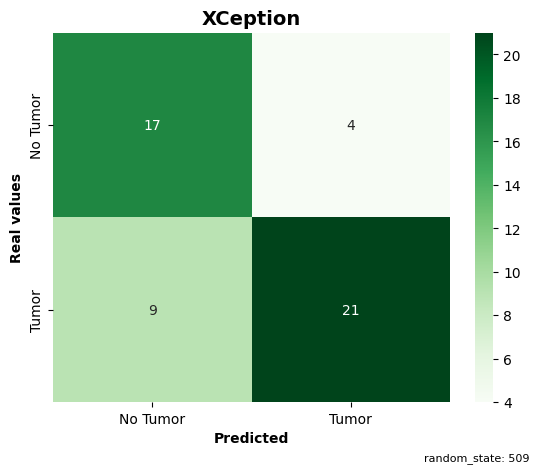

In [34]:
cf_matrix = confusion_matrix(y_test_labels, xception_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('XCeption', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_5_XCeption_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

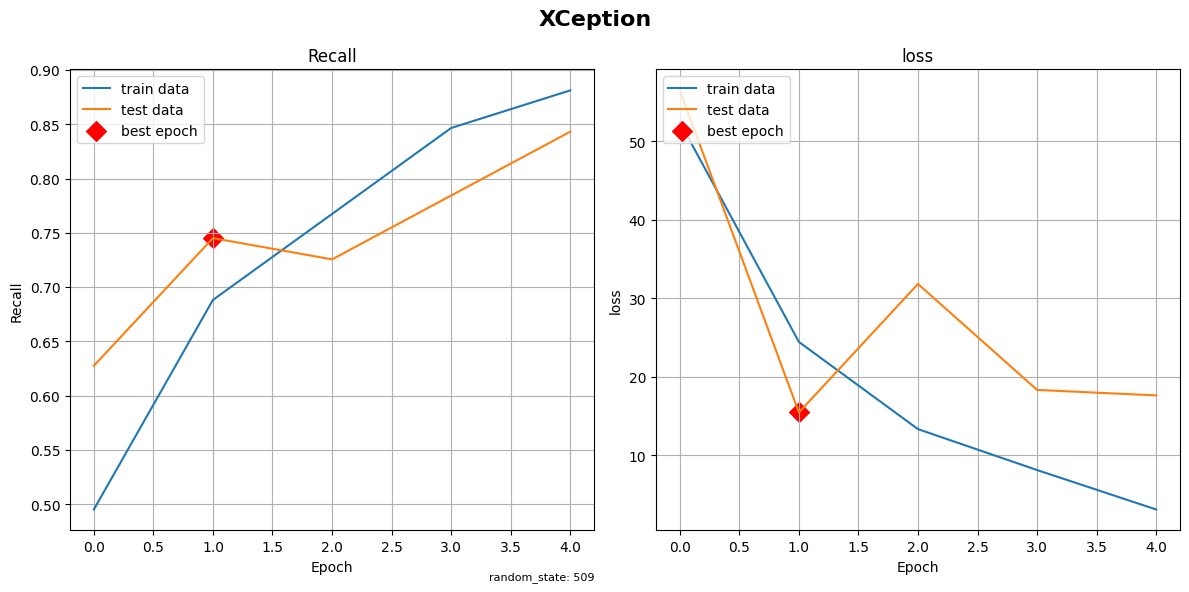

In [35]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('XCeption', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(xception_history.history['recall'], label='train data')
plt.plot(xception_history.history['val_recall'], label='test data')
plt.scatter(xception_epoch, xception_history.history['val_recall'][xception_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(xception_history.history['loss'], label='train data')
plt.plot(xception_history.history['val_loss'], label='test data')
plt.scatter(xception_epoch, xception_history.history['val_loss'][xception_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_5_XCeption_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

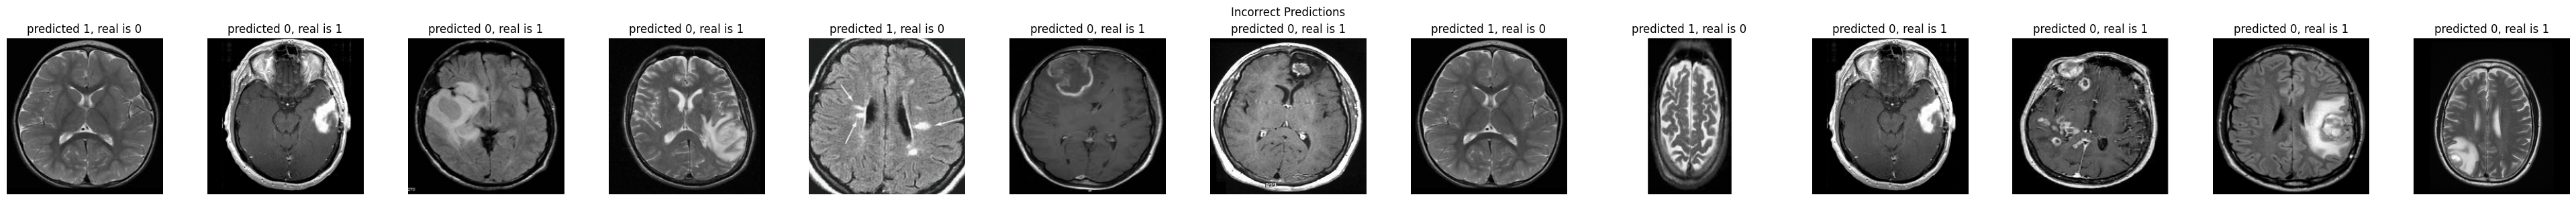

In [36]:
predicted_labels = np.argmax(xception_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### VI. EfficientNet

#### model structure

*EfficentNet is the most complex architecture in terms of layers considered for this problem. Version B4 used here has 300 layers. EfficentNet scale model dimensions in a balanced way, utilizng compund scaling method to optimize perfomance while minimizing computational costs.*

In [37]:
# preprocess images to fit for efficientnet
efficientnet_images = efficientnet.preprocess_input(images)
X_train, X_test, y_train, y_test = split_data(efficientnet_images)

efficientnet_base_model = efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

##### LAYERS FOR BINARY CLASSIFICATION

# XXX classification layer + freezing weights from imagenet
for layer in efficientnet_base_model.layers:
    layer.trainable = False 
x = layers.Flatten()(efficientnet_base_model.output)
x = layers.Dense(2, activation='softmax')(x) 

# XXX freezing all EXCEPT LAST 4 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in efficientnet_base_model.layers[:-6]:
#     layer.trainable = False 
# x = layers.Flatten()(efficientnet_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# XXX freezing all EXCEPT LAST 15 TRAINABLE LAYERS AND ACTIVATION LAYER
# for layer in efficientnet_base_model.layers[:-32]:
#     layer.trainable = False 
# x = layers.Flatten()(efficientnet_base_model.output)
# x = layers.Dense(2, activation='softmax')(x)

# assemble model
efficientnet_model = models.Model(inputs=efficientnet_base_model.input, outputs=x)

# make summary shorter (14 from head and 10 from tail)
efficientnet_model.summary(layer_range=(efficientnet_model.layers[0].name, efficientnet_model.layers[13].name), show_trainable=True)
print("\t. . .\t")
efficientnet_model.summary(layer_range=(efficientnet_model.layers[-14].name, efficientnet_model.layers[-1].name), show_trainable=True)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 224,     │         0 │ input_layer_5… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 224,     │         7 │ rescaling[0][… │   N   │
│ (Normalization)   │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_1       │ (None, 224,     │         0 │ normalization… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv_pad     │ (None, 225,     │         0 │ rescaling_1[0… │   -   │
│ (ZeroPadding2D)   │ 225, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │     1,296 │ stem_conv_pad… │   N   │
│ (Conv2D)          │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │       192 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_dwconv    │ (None, 112,     │       432 │ stem_activati… │   N   │
│ (DepthwiseConv2D) │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_bn        │ (None, 112,     │       192 │ block1a_dwcon… │   N   │
│ (BatchNormalizat… │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_activati… │ (None, 112,     │         0 │ block1a_bn[0]… │   -   │
│ (Activation)      │ 112, 48)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_squee… │ (None, 48)      │         0 │ block1a_activ… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_resha… │ (None, 1, 1,    │         0 │ block1a_se_sq… │   -   │
│ (Reshape)         │ 48)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_reduce │ (None, 1, 1,    │       588 │ block1a_se_re… │   N   │
│ (Conv2D)          │ 12)             │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 17,849,441 (68.09 MB)

 Trainable params: 175,618 (686.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

	. . .	


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ block7b_se_squee… │ (None, 2688)    │         0 │ block7b_activ… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_resha… │ (None, 1, 1,    │         0 │ block7b_se_sq… │   -   │
│ (Reshape)         │ 2688)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_reduce │ (None, 1, 1,    │   301,168 │ block7b_se_re… │   N   │
│ (Conv2D)          │ 112)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_expand │ (None, 1, 1,    │   303,744 │ block7b_se_re… │   N   │
│ (Conv2D)          │ 2688)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_se_excite │ (None, 7, 7,    │         0 │ block7b_activ… │   -   │
│ (Multiply)        │ 2688)           │           │ block7b_se_ex… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_project_… │ (None, 7, 7,    │ 1,204,224 │ block7b_se_ex… │   N   │
│ (Conv2D)          │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_project_… │ (None, 7, 7,    │     1,792 │ block7b_proje… │   N   │
│ (BatchNormalizat… │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_drop      │ (None, 7, 7,    │         0 │ block7b_proje… │   -   │
│ (Dropout)         │ 448)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block7b_add (Add) │ (None, 7, 7,    │         0 │ block7b_drop[… │   -   │
│                   │ 448)            │           │ block7a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_conv (Conv2D) │ (None, 7, 7,    │   802,816 │ block7b_add[0… │   N   │
│                   │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_bn            │ (None, 7, 7,    │     7,168 │ top_conv[0][0] │   N   │
│ (BatchNormalizat… │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ top_activation    │ (None, 7, 7,    │         0 │ top_bn[0][0]   │   -   │
│ (Activation)      │ 1792)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ flatten_5         │ (None, 87808)   │         0 │ top_activatio… │   -   │
│ (Flatten)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_5 (Dense)   │ (None, 2)       │   175,618 │ flatten_5[0][… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 17,849,441 (68.09 MB)

 Trainable params: 175,618 (686.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

#### fit model

In [38]:
# callback to stop epochs when satisfying outcome
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to be monitored to end alg
    patience=3,    # how much epochs without change to end algorithm
    min_delta=0.02, #if los changes slightly, patience won't take it into account           
    restore_best_weights=True # hold best epoch weights
)

# compile with categorical crossentropy, using adam optimizer, where metric to be valued is recall, accuracy
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall', 'accuracy'])

# fit data with validation
efficientnet_history = efficientnet_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
efficientnet_predictions = efficientnet_model.predict(X_test)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.4669 - loss: 4.4463 - recall: 0.4669 - val_accuracy: 0.8431 - val_loss: 2.7280 - val_recall: 0.8431
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.7506 - loss: 3.5606 - recall: 0.7506 - val_accuracy: 0.8627 - val_loss: 1.7822 - val_recall: 0.8627
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8004 - loss: 2.8311 - recall: 0.8004 - val_accuracy: 0.8824 - val_loss: 0.9366 - val_recall: 0.8824
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8883 - loss: 1.1224 - recall: 0.8883 - val_accuracy: 0.9412 - val_loss: 0.5664 - val_recall: 0.9412
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9019 - loss: 1.1265 - recall: 0.9019 - val_accuracy: 0.8627 - val_loss: 1.0822 - val_recall: 0.8627
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9250 - loss: 0.6866 - recall: 0.9250 - val_accuracy: 0.9412 - val_loss: 0.7444 - val_recall: 0.9412
Epoch 7/30
7/7 ━━━━━━━━━━━━━

#### outcome
for train_test_split random_state=112<br/><br/>

**1st attempt - all layers freezed, output layer**(Run - 2m 37s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 63s     | 0.5785         | 3.1571       | 0.7647           | 4.4812         |
| 2     | 24s     | 0.7915         | 3.1664       | 0.8039           | 1.9590         |
| 3     | 24s     | 0.8850         | 0.7603       | 0.8235           | 2.2640         |
| 4     | 24s     | 0.8884         | 0.9058       | 0.8824           | 1.0375         |
| 5     | 24s     | 0.9301         | 0.2435       | 0.8431           | 1.3917         |

<br/><br/>
**2nd attempt - all layers freezed expect last 4 trainable layers, output layer**(Run - 2m 52s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 47s     | 0.6369         | 4.2191       | 0.7647           | 2.8928         |
| 2     | 23s     | 0.8282         | 2.3399       | 0.8039           | 2.3163         |
| 3     | 25s     | 0.8479         | 1.9272       | 0.8431           | 2.1018         |
| 4     | 23s     | 0.9271         | 0.8485       | 0.8824           | 1.7012         |
| 5     | 24s     | 0.9785         | 0.3446       | 0.8627           | 1.2193         |

<br/><br/>
**3rd attempt - all layers freezed expect last 16 trainable layers, output layer**(Run - 2m 42s)(metric - recall)
| Epoch | 7 steps | Recall (train) | Loss (train) | Val_recall (val) | Val_loss (val) |
|-------|---------|----------------|--------------|------------------|----------------|
| 1     | 52s     | 0.6072         | 4.5471       | 0.8039           | 1.2214         |
| 2     | 27s     | 0.9405         | 0.3426       | 0.8824           | 0.8662         |
| 3     | 27s     | 0.9532         | 0.2302       | 0.8431           | 1.3147         |
| 4     | 27s     | 0.9727         | 0.0839       | 0.8235           | 3.2975         |
| 5     | 31s     | 0.9704         | 0.1953       | 0.8039           | 4.5883         |

classification report

In [39]:
efficientnet_epoch = min(range(len(efficientnet_history.history['val_loss'])), key=lambda i: efficientnet_history.history['val_loss'][i])
print(f'Best epoch is: {efficientnet_epoch + 1}')

y_test_labels = np.argmax(y_test, axis=1)
efficientnet_predictions_classes = np.argmax(efficientnet_predictions, axis=1)
print("\nClassification report:")
print(classification_report(y_test_labels, efficientnet_predictions_classes))

Best epoch is: 4

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.91      1.00      0.95        30

    accuracy                           0.94        51
   macro avg       0.95      0.93      0.94        51
weighted avg       0.95      0.94      0.94        51



confusion matrix

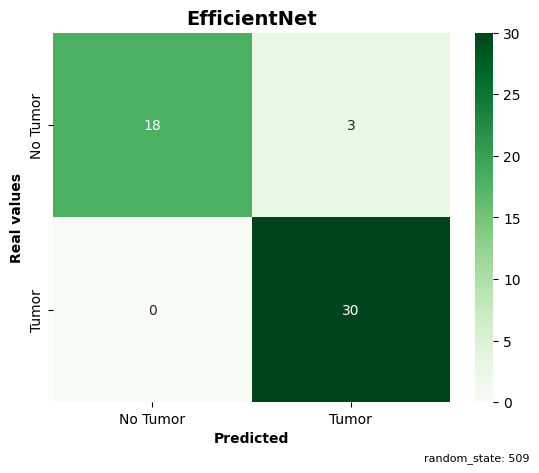

In [40]:
cf_matrix = confusion_matrix(y_test_labels, efficientnet_predictions_classes)
labels_heatmap = ['No Tumor', 'Tumor']
heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels_heatmap, yticklabels=labels_heatmap)
plt.title('EfficientNet', fontweight='bold', fontsize=14)
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel('Real values', fontweight='bold')

plt.text(1.2, -0.15, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)
plt.savefig("figures/rs_509_6_EfficientNet_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

recall & accuracy

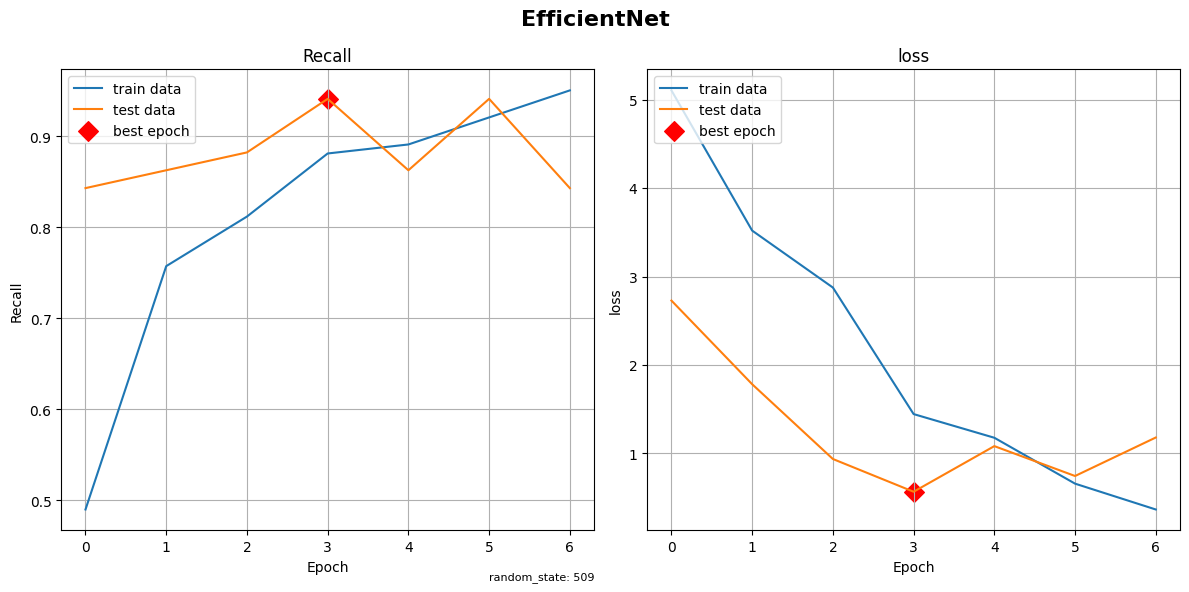

In [41]:
plt.figure(figsize=(12, 6))

# Name
plt.suptitle('EfficientNet', fontweight='bold', fontsize='16')
# Recall
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['recall'], label='train data')
plt.plot(efficientnet_history.history['val_recall'], label='test data')
plt.scatter(efficientnet_epoch, efficientnet_history.history['val_recall'][efficientnet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=plt.gca().transAxes)

# loss
plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='train data')
plt.plot(efficientnet_history.history['val_loss'], label='test data')
plt.scatter(efficientnet_epoch, efficientnet_history.history['val_loss'][efficientnet_epoch], color='red', marker='D', s=100, label='best epoch')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()


plt.tight_layout()
plt.savefig("figures/rs_509_6_EfficientNet_recall_loss.png", dpi=300, bbox_inches='tight')
plt.show()

show images not detected

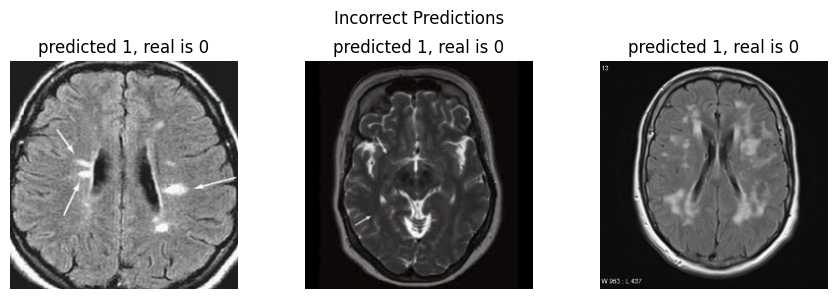

In [42]:
predicted_labels = np.argmax(efficientnet_predictions, axis=1)
incorrect_indices = np.where(predicted_labels != y_test_labels)[0]

num_images = len(incorrect_indices)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
fig.suptitle('Incorrect Predictions')
if num_images == 1:
    axes = [axes]
for ax, idx in zip(axes, incorrect_indices):
    ax.imshow(X_test[idx])
    ax.set_title(f'predicted {predicted_labels[idx]}, real is {y_test_labels[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Results Summary

all-in-one recall loss comparison 

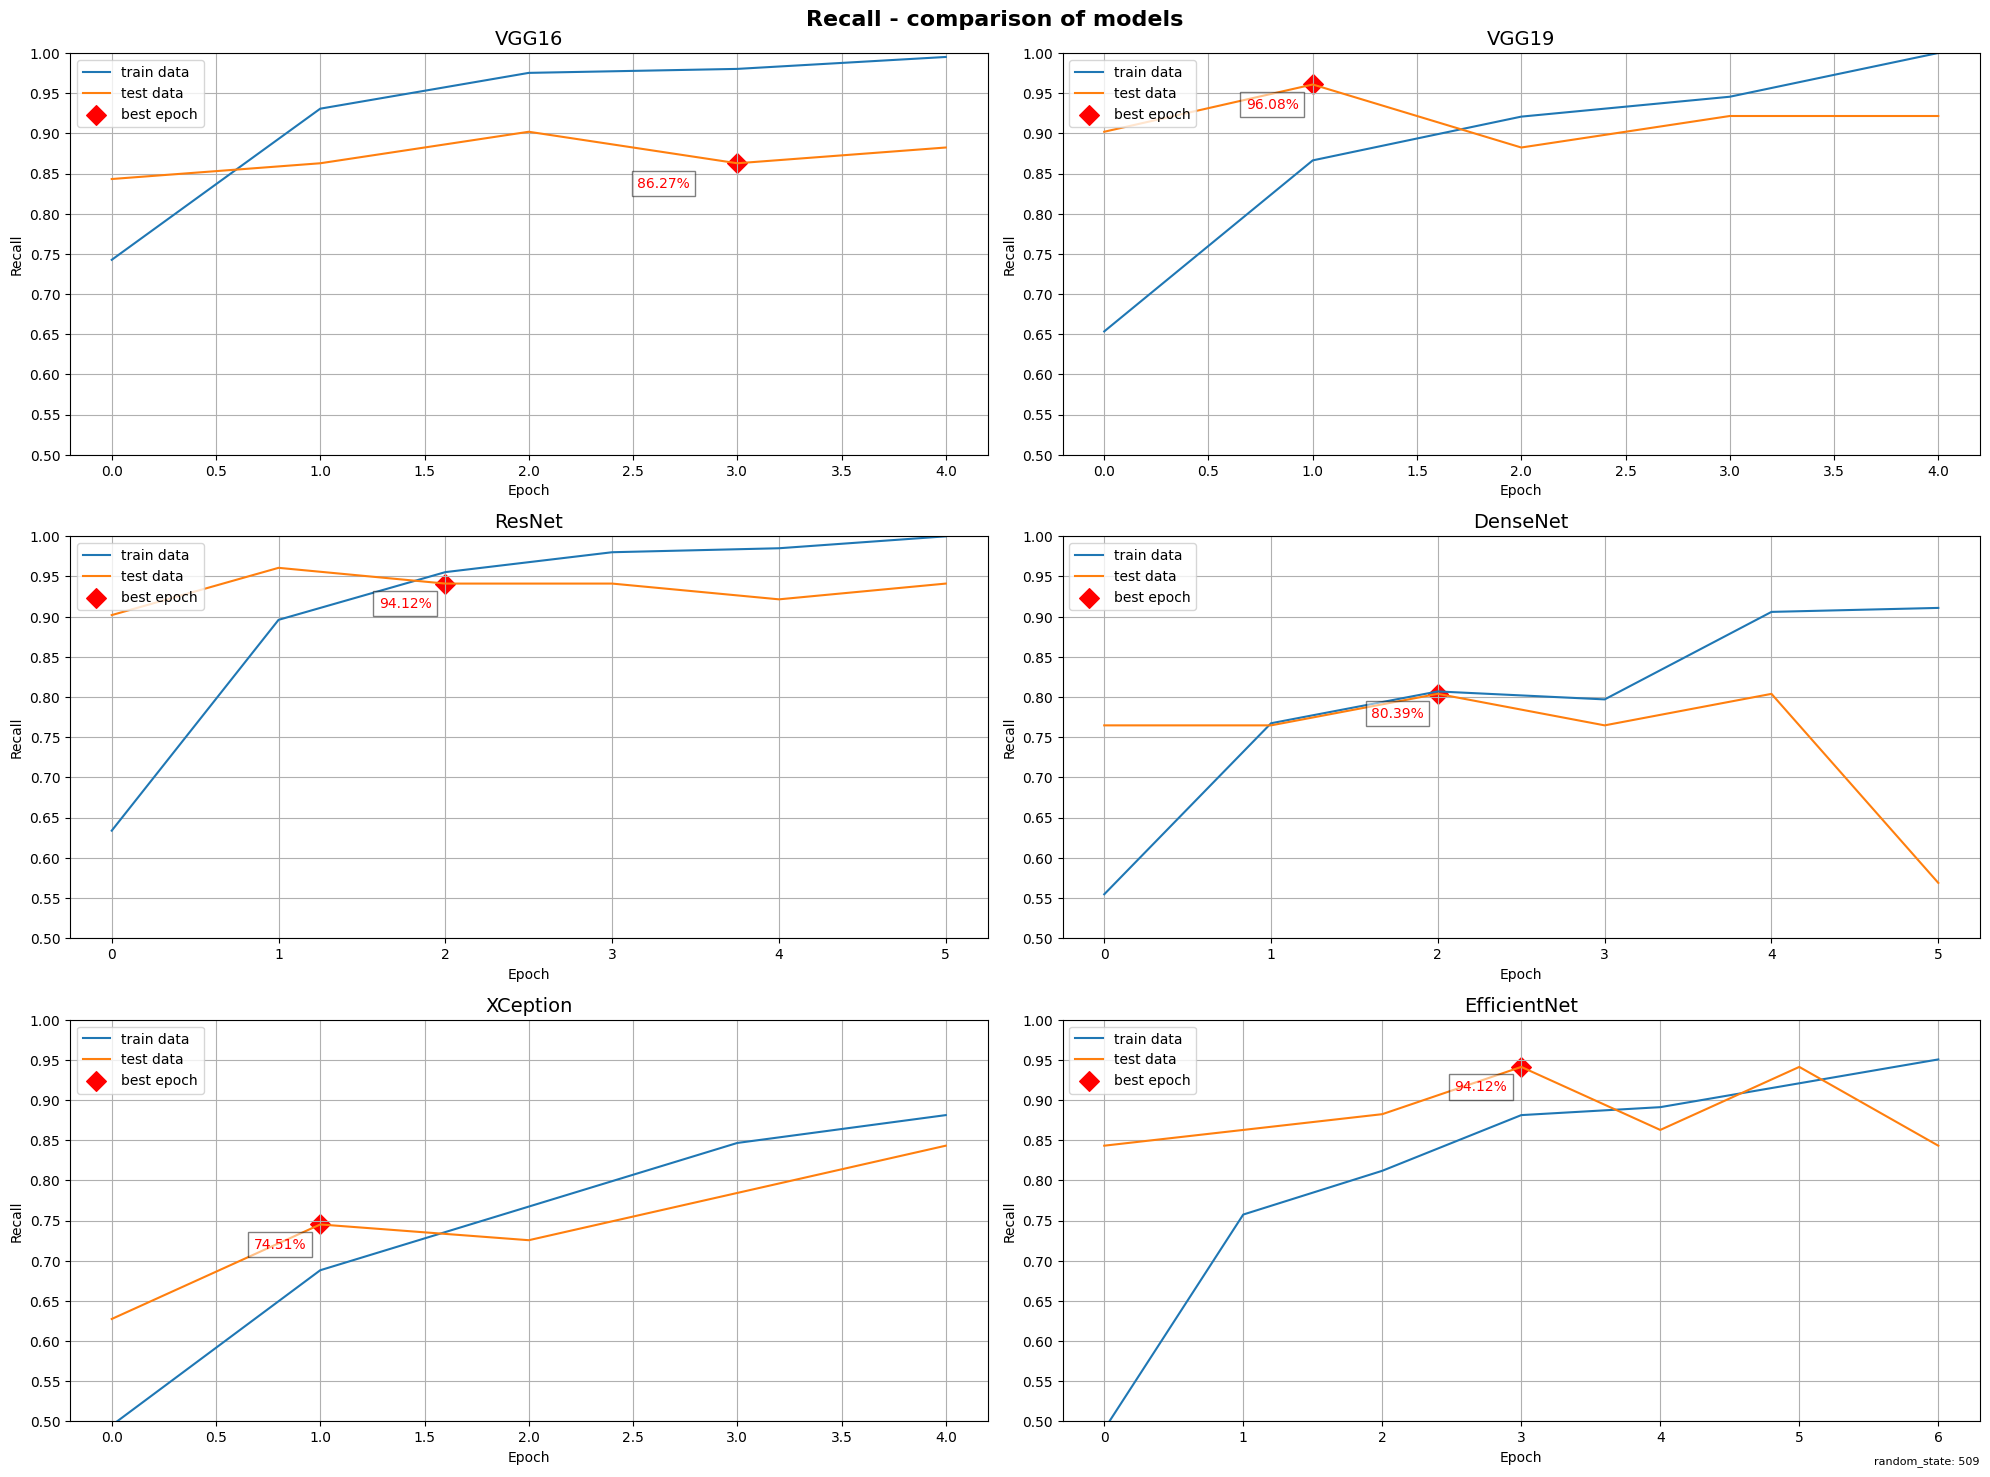

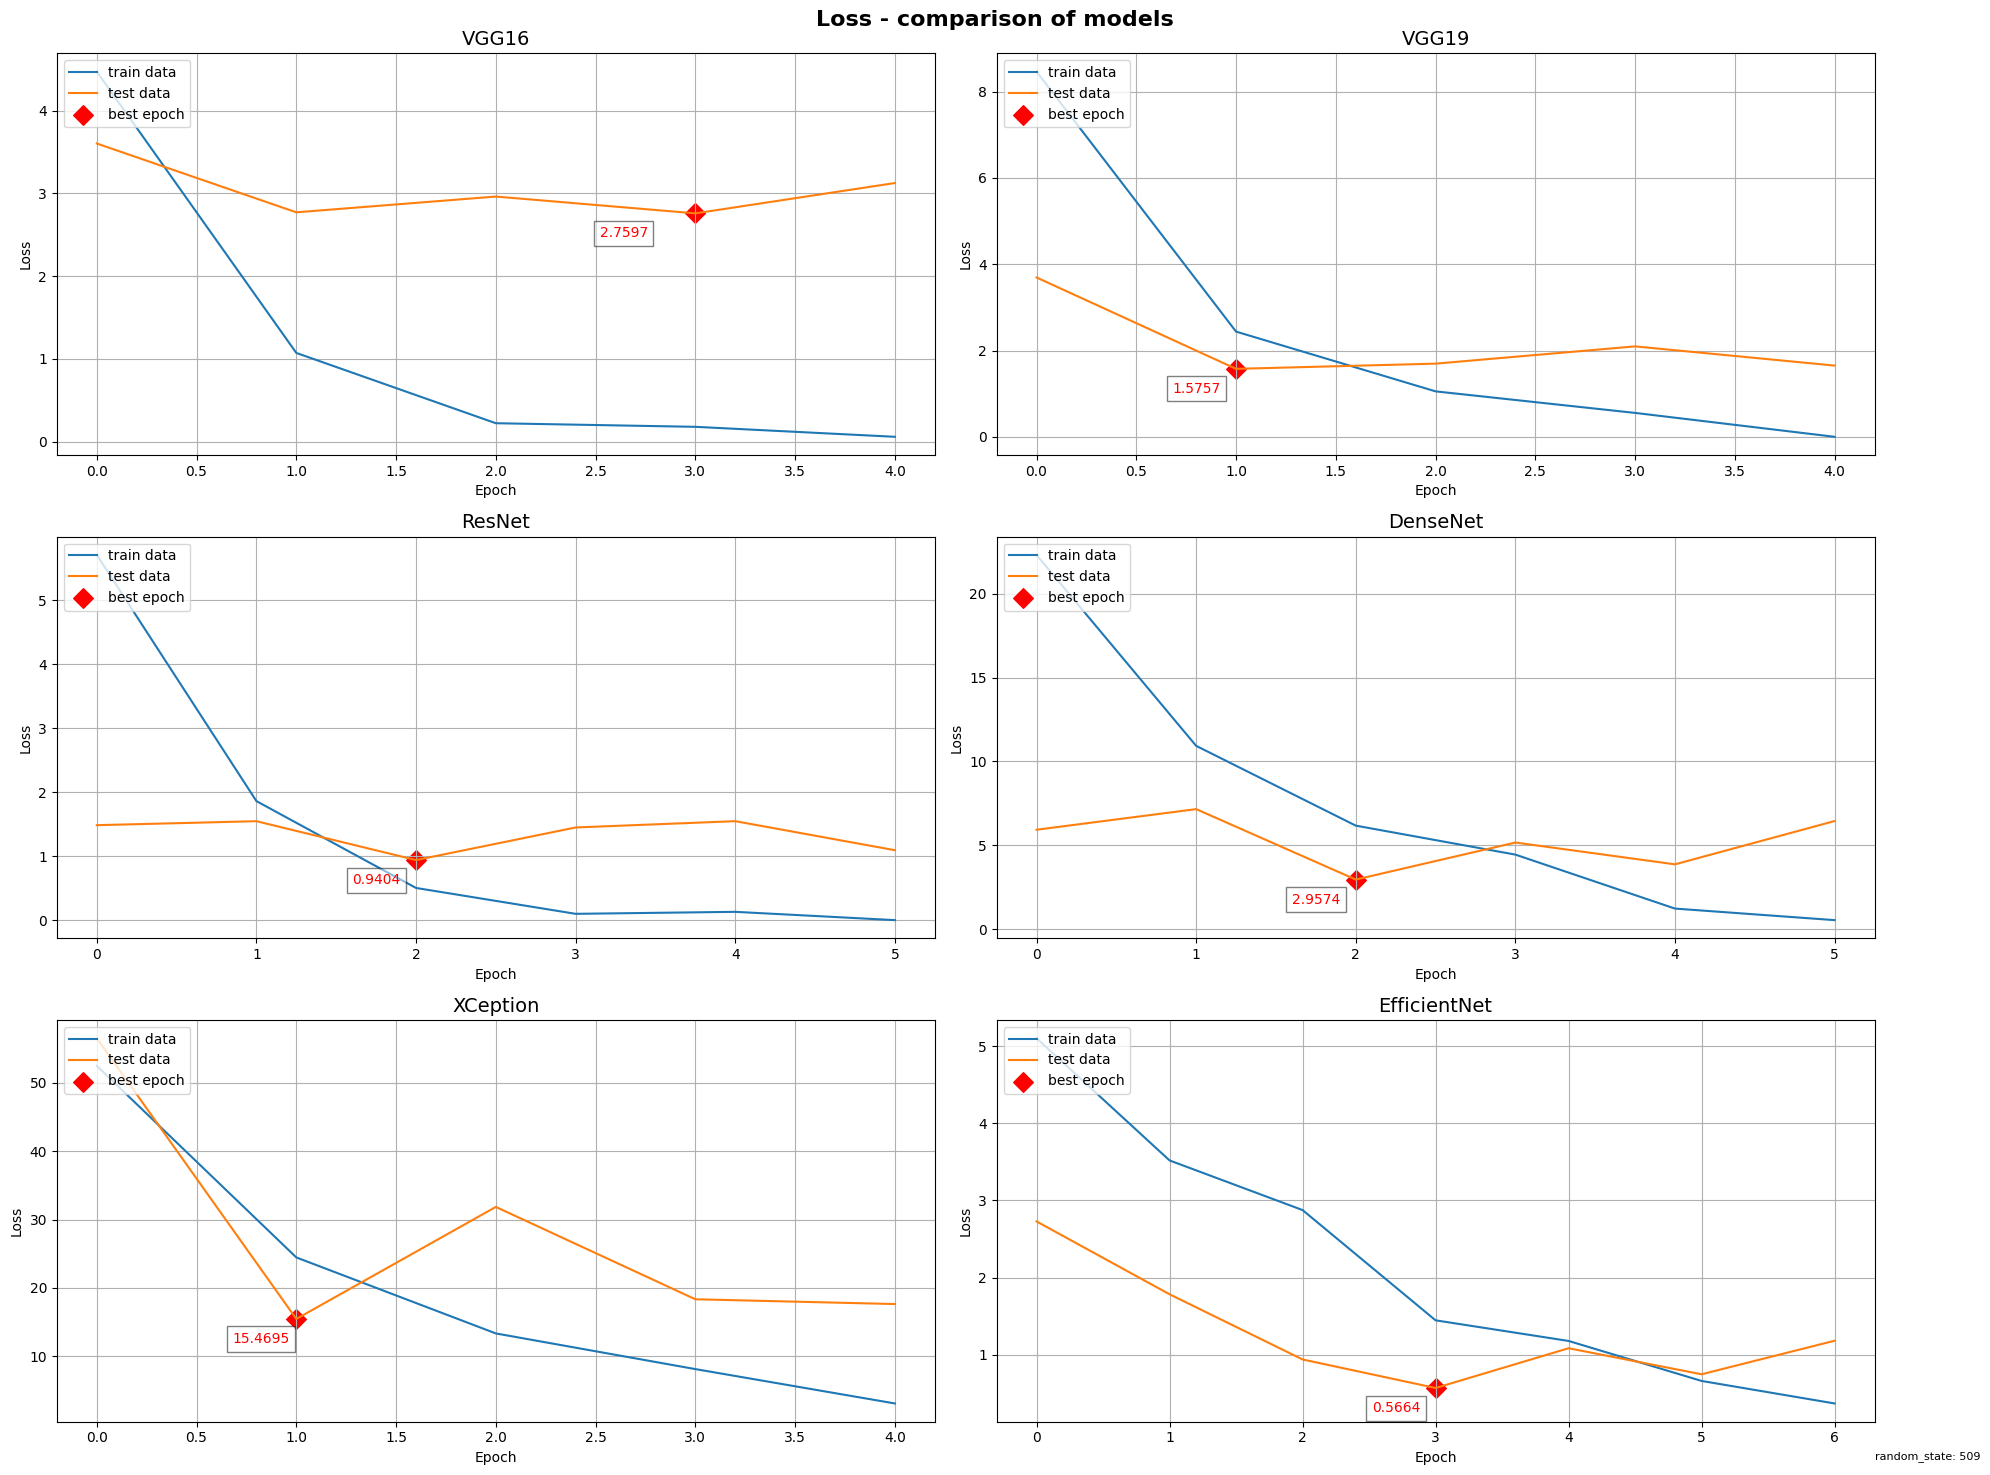

In [43]:
history_list = [vgg16_history, vgg19_history, resnet_history, densenet_history, xception_history, efficientnet_history]
titles = ['VGG16', 'VGG19', 'ResNet', 'DenseNet', 'XCeption', 'EfficientNet']
best_epochs = [vgg16_epoch, vgg19_epoch, resnet_epoch, densenet_epoch, xception_epoch, efficientnet_epoch]


# recall chart
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Recall - comparison of models', fontweight='bold', fontsize=16)
for i, (history, title, best_epoch) in enumerate(zip(history_list, titles, best_epochs)):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'{title}', fontsize=14)
    ax.plot(history.history['recall'], label='train data')
    ax.plot(history.history['val_recall'], label='test data')
    best_epoch_recall = history.history['val_recall'][best_epoch]
    ax.scatter(best_epoch, best_epoch_recall, color='red', marker='D', s=100, label='best epoch')
    text_position = best_epoch_recall-(0.025)
    epochs = best_epoch+3
    text_h_position = best_epoch-0.08*epochs
    ax.text(text_h_position, text_position, f'{(best_epoch_recall*100):.2f}%', color='red', va='center', ha='left', bbox=dict(facecolor='white', alpha=0.5))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Recall')
    ax.set_yticks([0.5 + 0.05*i for i in range(11)])
    ax.legend(loc='upper left')
    ax.set_ylim(0.5, 1)
    ax.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='right', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig("figures/rs_509_comparison_recall.png", dpi=300, bbox_inches='tight')
plt.show()



# loss chart
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Loss - comparison of models', fontweight='bold', fontsize=16)
for i, (history, title, best_epoch) in enumerate(zip(history_list, titles, best_epochs)):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'{title}', fontsize=14)
    ax.plot(history.history['loss'], label='train data')
    ax.plot(history.history['val_loss'], label='test data')
    min_loss = history.history['val_loss'][best_epoch]
    ax.scatter(best_epoch, min_loss, color='red', marker='D', s=100, label='best epoch')
    ymin, ymax = ax.get_ylim()
    text_position = min_loss-(0.05*(ymax-ymin))
    epochs = best_epoch+3
    text_h_position = best_epoch-0.08*epochs
    ax.text(text_h_position, text_position, f'{min_loss:.4f}', color='red', va='center', ha='left', bbox=dict(facecolor='white', alpha=0.5))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper left')
    ax.grid()
plt.text(1, -0.1, f"random_state: {random_state}", fontsize=8, color='black', ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.savefig("figures/rs_509_comparison_loss.png", dpi=300, bbox_inches='tight')
plt.show()

In [44]:
timer_stop = time.time()

execution_time = timer_stop - timer_start
min_ = int(execution_time // 60)
sec_ = int(execution_time % 60)
print(f"Full runtime: {min_}m {sec_}s")

Full runtime: 17m 36s


*In tested CNN's configurations of different structures I left one which suited best for test data by recall metric. In more complex networks, practic of leaving more ending neurons to be trained mostly turned out to be worse than remain weigths from imagenet.*

In [45]:
timer_stop = time.time()

execution_time = timer_stop - timer_start
min_ = int(execution_time // 60)
sec_ = int(execution_time % 60)
print(f"Full runtime: {min_}m {sec_}s")

Full runtime: 17m 36s
